# MLFlow Experiment Analysis

This notebook demonstrates how to fetch experiment results from MLFlow, compare runs, and visualize performance using radar charts.

In [15]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from mlflow.tracking import MlflowClient
from typing import List, Dict, Any
import mlflow.types.schema
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv(dotenv_path="../.env")

# Set tracking URI (adjust if using a remote server)
client = MlflowClient()

print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Tracking URI: https://mlflow.rotary-insight.ir/


## 1. Fetching Experiment Results

We'll fetch all runs from a specific experiment or all experiments.

In [ ]:
def get_runs_df(experiment_names: List[str] = None) -> pd.DataFrame:
    """Fetches runs from specified experiments and returns a DataFrame."""
    if experiment_names:
        experiment_ids = []
        for name in experiment_names:
            exp = mlflow.get_experiment_by_name(name)
            if exp:
                experiment_ids.append(exp.experiment_id)
            else:
                print(f"Warning: Experiment '{name}' not found.")
    else:
        # Fetch all experiments if none specified
        experiments = mlflow.search_experiments()
        experiment_ids = [exp.experiment_id for exp in experiments]

    if not experiment_ids:
        print("No experiments found.")
        return pd.DataFrame()

    runs = mlflow.search_runs(experiment_ids=experiment_ids)
    return runs

# Example: Fetch runs from all experiments
runs_df = get_runs_df(["pu_no_noise"])

# Display basic info
if not runs_df.empty:
    print(f"Fetched {len(runs_df)} runs.")
    display_cols = ['tags.mlflow.runName' ,'run_id', 'experiment_id', 'status', 'start_time'] 
    # Add metrics if available
    metric_cols = [c for c in runs_df.columns if c.startswith('metrics.')]
    display_cols.extend(metric_cols[:5]) # Show first 5 metrics
    
    display(runs_df[display_cols])
else:
    print("No runs found.")

Fetched 7 runs.


,tags.mlflow.runName,run_id,experiment_id,status,start_time,metrics.epoch_train_acc,metrics.epoch_val_loss,metrics.epoch_train_loss,metrics.epoch_val_acc,metrics.train_loss
0,pu_no_noise__resnet1d__0,a06fa985c9cb4e84a218ad2c34345143,11,RUNNING,2025-12-12 07:57:01.982000+00:00,0.945031,0.062017,0.130233,0.971167,NaN
1,pu_no_noise__efficientnet1d__0,0a327401ea094cdd8d844824041fb98c,11,FINISHED,2025-12-11 23:35:03.574000+00:00,0.999427,0.337180,0.002767,0.923167,0.002767
2,pu_no_noise__cnn_selfattention__0,b2a242836ec04a76a24f10235fbe7531,11,FINISHED,2025-12-11 23:24:15.694000+00:00,0.992385,0.299264,0.020718,0.952500,0.020225
3,pu_no_noise__cnn_bilstm__0,b13913406ec344048ed99496aa6d26fe,11,FINISHED,2025-12-11 23:11:14.245000+00:00,0.999677,0.126309,0.000905,0.978167,0.000905
4,pu_no_noise__densenet1d__0,6aeb07cd05fc4eea9af6795dd1d6da79,11,FINISHED,2025-12-11 22:52:42.001000+00:00,0.994073,0.073394,0.017819,0.977833,0.017819
5,pu_no_noise__dpccnn__0,02d09e6c0e87453b8d04e3a52611328f,11,FINISHED,2025-12-11 22:39:18.155000+00:00,0.990573,0.057735,0.025611,0.982667,0.025611
6,pu_no_noise__dsicnn__0,8219518ee9624f3290c63dcadb6e35a9,11,FINISHED,2025-12-11 22:29:33.374000+00:00,0.975521,0.069414,0.064431,0.972417,0.064208


In [4]:
model_names = {
    "pu_no_noise__efficientnet1d__0": "EfficientNet1D",
    "pu_no_noise__dpccnn__0": "DPCCNN",
    "pu_no_noise__dsicnn__0": "DSICNN",
    "pu_no_noise__cnn_selfattention__0": "CNN+SelfAttention",
    "pu_no_noise__cnn_bilstm__0": "CNN+BiLSTM",
    "pu_no_noise__densenet1d__0": "DenseNet1D",
    "pu_no_noise__transformer_encoder_classifier__0": "TransformerEncoder",
    "pu_no_noise__resnet1d__0": "ResNet1D",
}

## 2. Comparing Runs (Detailed Table)

We'll extract detailed metrics (Precision, Recall, F1) from the `metrics.json` artifact logged for each run.

In [5]:
def get_detailed_metrics(run_id: str) -> Dict[str, Any]:
    """Downloads and parses metrics.json artifact for a run."""
    try:
        local_path = client.download_artifacts(run_id, "metrics.json", dst_path=".")
        with open(local_path, 'r') as f:
            metrics = json.load(f)
        os.remove(local_path) # Clean up
        return metrics
    except Exception as e:
        print(f"Could not fetch metrics.json for run {run_id}: {e}")
        return {}

def create_comparison_table(runs_df: pd.DataFrame) -> pd.DataFrame:
    """Creates a comparison table with Precision, Recall, and F1 Score."""
    comparison_data = []

    for _, run in runs_df.iterrows():
        run_id = run['run_id']
        
        # Basic metrics from MLFlow runs table
        entry = {
            'run_id': run_id,
            'experiment_id': run.get('experiment_id'),
            'model': model_names.get(run.get('tags.mlflow.runName', ''), run.get('params.model_name', 'N/A')),
            'val_acc': run.get('metrics.val_acc', 0),
            'val_loss': run.get('metrics.val_loss', 0),
        }

        # Detailed metrics from artifact
        detailed_metrics = get_detailed_metrics(run_id)
        if 'classification_report' in detailed_metrics:
            report = detailed_metrics['classification_report']
            # Get weighted average metrics
            if 'weighted avg' in report:
                entry['precision'] = report['weighted avg']['precision']
                entry['recall'] = report['weighted avg']['recall']
                entry['f1-score'] = report['weighted avg']['f1-score']
        
        comparison_data.append(entry)

    return pd.DataFrame(comparison_data)

if not runs_df.empty:
    comparison_df = create_comparison_table(runs_df)
    # Sort by Validation Accuracy
    comparison_df = comparison_df.sort_values(by='val_acc', ascending=False)
    display(comparison_df)
else:
    print("No runs to compare.")

31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


/home/soroosh/anaconda3/envs/kan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not fetch metrics.json for run a06fa985c9cb4e84a218ad2c34345143: Failed to download artifacts from path 'metrics.json', please ensure that the path is correct.
31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


,run_id,experiment_id,model,val_acc,val_loss,precision,recall,f1-score
5,02d09e6c0e87453b8d04e3a52611328f,11,DPCCNN,0.983833,0.043222,0.983847,0.983833,0.983833
4,6aeb07cd05fc4eea9af6795dd1d6da79,11,DenseNet1D,0.980417,0.057016,0.980470,0.980417,0.980439
3,b13913406ec344048ed99496aa6d26fe,11,CNN+BiLSTM,0.979167,0.098947,0.979223,0.979167,0.979189
6,8219518ee9624f3290c63dcadb6e35a9,11,DSICNN,0.974167,0.065830,0.974248,0.974167,0.974169
2,b2a242836ec04a76a24f10235fbe7531,11,CNN+SelfAttention,0.952500,0.299264,0.952715,0.952500,0.952534
1,0a327401ea094cdd8d844824041fb98c,11,EfficientNet1D,0.927583,0.196963,0.927658,0.927583,0.927591
0,a06fa985c9cb4e84a218ad2c34345143,11,ResNet1D,NaN,NaN,NaN,NaN,NaN


In [6]:
comparison_df.to_excel("mlflow_model_comparison.xlsx")

## 3. Radar Chart Visualization

We'll visualize the performance of the top models using a radar chart, comparing Accuracy, Precision, Recall, and F1 Score.

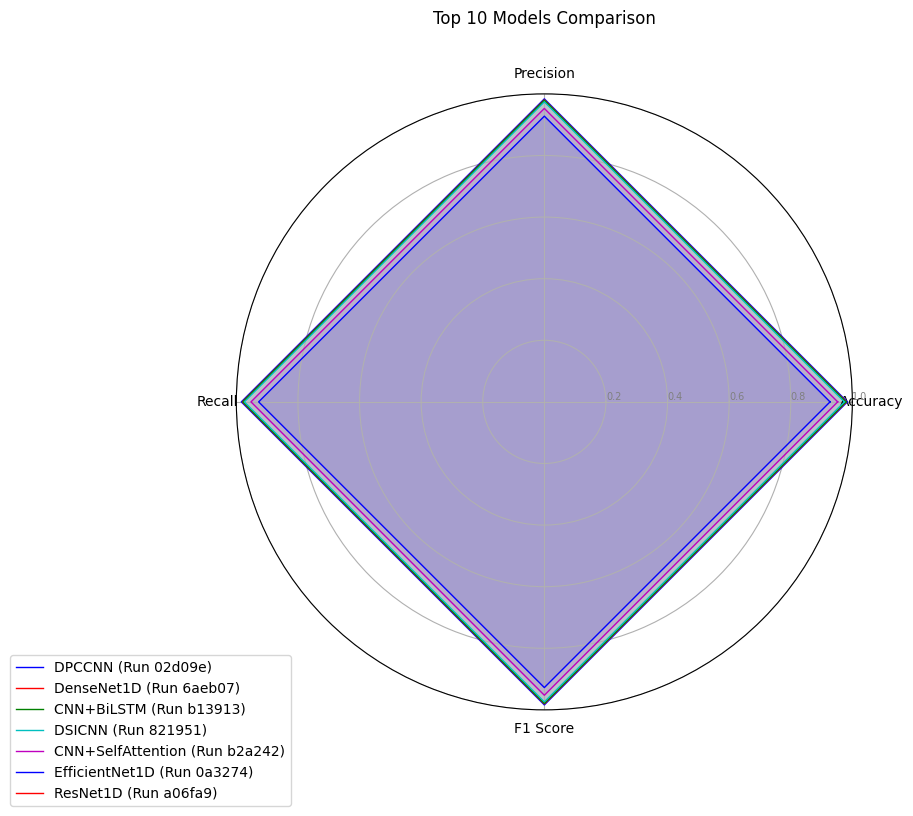

In [9]:
def plot_model_comparison(comparison_df: pd.DataFrame, top_n: int = 3):
    """Plots a radar chart comparing the top N models."""
    if comparison_df.empty:
        print("No data to plot.")
        return

    # Select top N models based on Validation Accuracy
    top_models = comparison_df.sort_values(by='val_acc', ascending=False).head(top_n)
    
    # Metrics to compare
    metrics = ['val_acc', 'precision', 'recall', 'f1-score']
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # Number of variables
    N = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # Close the loop
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw axis lines
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    # Draw y labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    
    # Plot each model
    colors = ['b', 'r', 'g', 'c', 'm']
    for i, (_, row) in enumerate(top_models.iterrows()):
        values = [row.get(m, 0) for m in metrics]
        values += values[:1] # Close the loop
        
        model_name = f"{row['model']} (Run {row['run_id'][:6]})"
        color = colors[i % len(colors)]
        
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model_name, color=color)
        ax.fill(angles, values, color, alpha=0.1)
        
    plt.title(f"Top {top_n} Models Comparison", y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

if not runs_df.empty and not comparison_df.empty:
    plot_model_comparison(comparison_df, top_n=10)